# Racial Demographics of Oil Well Locations

## Bring in Oil Wells Data

In [374]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [375]:
# bring in idle wells data
wells = pd.read_csv('LAC_wells_onshore2.csv')

In [376]:
# test it
wells.head()

,LeaseName,WellNumber,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,Latitude,Longitude
0,Chanchorena,1,Plugged,OG,Oil & Gas,S1375,Steven A. Sayce,33.593762,-118.023328
1,Lease by San Pedro-Point Fermin Oil & Gas Co.,1,Plugged,DH,Dry Hole,7633,San Pedro-Point Fermin Oil & Gas Co.,33.705338,-118.293968
2,Lease by Lighthouse Oil Co.,1,Idle,OG,Oil & Gas,9707,Lighthouse Oil Co.,33.708696,-118.291480
3,Lease by Los Angeles Harbor Oil Dev. Co.,1,Idle,OG,Oil & Gas,5421,Los Angeles Harbor Oil Dev. Co.,33.716400,-118.302544
4,Sepulveda,1,Plugged,DH,Dry Hole,8166,"Surety Holding Co., Ltd.",33.721802,-118.326088


In [377]:
wells.WellStatus.value_counts()

Plugged        17039
Idle            3617
Active          3360
Canceled         157
New               61
PluggedOnly       12
Name: WellStatus, dtype: int64

In [378]:
# convert pandas dataframe to geodataframe
geowells = gpd.GeoDataFrame(wells, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(wells.Longitude, wells.Latitude))

In [379]:
# test it
geowells.head()

,LeaseName,WellNumber,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,Latitude,Longitude,geometry
0,Chanchorena,1,Plugged,OG,Oil & Gas,S1375,Steven A. Sayce,33.593762,-118.023328,POINT (-118.02333 33.59376)
1,Lease by San Pedro-Point Fermin Oil & Gas Co.,1,Plugged,DH,Dry Hole,7633,San Pedro-Point Fermin Oil & Gas Co.,33.705338,-118.293968,POINT (-118.29397 33.70534)
2,Lease by Lighthouse Oil Co.,1,Idle,OG,Oil & Gas,9707,Lighthouse Oil Co.,33.708696,-118.291480,POINT (-118.29148 33.70870)
3,Lease by Los Angeles Harbor Oil Dev. Co.,1,Idle,OG,Oil & Gas,5421,Los Angeles Harbor Oil Dev. Co.,33.716400,-118.302544,POINT (-118.30254 33.71640)
4,Sepulveda,1,Plugged,DH,Dry Hole,8166,"Surety Holding Co., Ltd.",33.721802,-118.326088,POINT (-118.32609 33.72180)


In [380]:
geowells.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

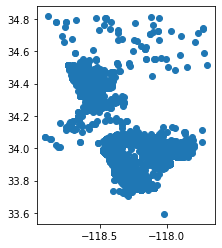

In [381]:
geowells.plot()

In [382]:
wellsIDLE=geowells.loc[geowells['WellStatus']=='Idle']
wellsIDLE.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3617 entries, 2 to 24232
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LeaseName   3617 non-null   object  
 1   WellNumber  3617 non-null   object  
 2   WellStatus  3617 non-null   object  
 3   WellType    3617 non-null   object  
 4   WellTypeLa  3617 non-null   object  
 5   OperatorCo  3617 non-null   object  
 6   OperatorNa  3617 non-null   object  
 7   Latitude    3617 non-null   float64 
 8   Longitude   3617 non-null   float64 
 9   geometry    3617 non-null   geometry
dtypes: float64(2), geometry(1), object(7)
memory usage: 310.8+ KB


In [383]:
# testing
wellsIDLE.sample(5)

,LeaseName,WellNumber,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,Latitude,Longitude,geometry
19196,Masselin,5,Idle,OG,Oil & Gas,U0200,Union Oil Company of California,34.058384,-118.353043,POINT (-118.35304 34.05838)
19555,Lease by John Alton,2,Idle,OG,Oil & Gas,9594,John Alton,34.063648,-118.256416,POINT (-118.25642 34.06365)
19462,Lease by Chas. V. Hall,25,Idle,OG,Oil & Gas,9541,Chas. V. Hall,34.063339,-118.273163,POINT (-118.27316 34.06334)
13723,Bell,439-F,Idle,OG,Oil & Gas,11583,"WG Holdings SPV, LLC",33.944321,-118.067398,POINT (-118.06740 33.94432)
8024,"Lease by Signal Hill Petroleum, Inc.",C56,Idle,OG,Oil & Gas,S3625,"Signal Hill Petroleum, Inc.",33.807072,-118.168945,POINT (-118.16895 33.80707)


## Bring in Census Data

In [384]:
# now lets bring in the census tracts using the ACS 2019 five yr data
tracts=gpd.read_file('acs2019.geojson')

In [385]:
tracts.sample()

,geoid,name,B02001001,"B02001001, Error",B02001002,"B02001002, Error",B02001003,"B02001003, Error",B02001004,"B02001004, Error",...,"B02001006, Error",B02001007,"B02001007, Error",B02001008,"B02001008, Error",B02001009,"B02001009, Error",B02001010,"B02001010, Error",geometry
604,14000US06037212306,"Census Tract 2123.06, Los Angeles, CA",3413.0,406.0,734.0,370.0,35.0,43.0,75.0,94.0,...,12.0,1150.0,424.0,115.0,125.0,109.0,120.0,6.0,20.0,"MULTIPOLYGON (((-118.29653 34.05773, -118.2953..."


In [386]:
# trim the data to the bare minimum columns
tracts = tracts[['geoid', 'name', 'geometry']]

In [387]:
tracts.sample()

,geoid,name,geometry
1362,14000US06037462001,"Census Tract 4620.01, Los Angeles, CA","MULTIPOLYGON (((-118.14614 34.16888, -118.1438..."


In [388]:
# drop the beginning of the geoid to make it match the FIPS column in the stats sheet
tracts['geoid'] = tracts['geoid'].str.replace('14000US','')
tracts.tail()

,geoid,name,geometry
2342,06037980033,"Census Tract 9800.33, Los Angeles, CA","MULTIPOLYGON (((-118.24897 33.75590, -118.2470..."
2343,06037990100,"Census Tract 9901, Los Angeles, CA","MULTIPOLYGON (((-118.95114 33.99643, -118.9505..."
2344,06037990200,"Census Tract 9902, Los Angeles, CA","MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
2345,06037990300,"Census Tract 9903, Los Angeles, CA","MULTIPOLYGON (((-118.47656 33.75038, -118.4661..."
2346,16000US0644000,"Los Angeles, CA","MULTIPOLYGON (((-118.66818 34.18987, -118.6681..."


In [389]:
tracts=tracts.drop(2346)


In [390]:
tracts.columns = ['FIPS', 'name', 'geometry']

In [391]:
tracts.sample()

,FIPS,name,geometry
2005,06037603006,"Census Tract 6030.06, Los Angeles, CA","MULTIPOLYGON (((-118.30914 33.88853, -118.3091..."


In [392]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2346 entries, 0 to 2345
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FIPS      2346 non-null   object  
 1   name      2346 non-null   object  
 2   geometry  2346 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 73.3+ KB


In [393]:
# converting the FIPS from an object to an int64
tracts.FIPS=tracts.FIPS.astype(int)

In [394]:
# checking
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2346 entries, 0 to 2345
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FIPS      2346 non-null   int64   
 1   name      2346 non-null   object  
 2   geometry  2346 non-null   geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 73.3+ KB


In [395]:
# now to bring in race data
stats = pd.read_csv('acs2019 five year stats.csv')

In [396]:
stats.sample(5)

,FIPS,Area Name,Census Tract,Total Population:,Total: White,Total: Black,Total: AmerIndian,Total: Asian,Total: Hawaiian and PacIslander,Total: Other,...,% Total: Black,% Total: AmerIndian,% Total: Asian,% Total: Hawaiian and PacIslander,% Total: Other,% Total: Mixed,Total: Not Hispanic or Latino,Total: Hispanic or Latino,% Total: Not Hispanic or Latino,% Total: Hispanic or Latino
198,6037124300,Census Tract 1243,124300,2988,2500,65,0,155,0,194,...,2.18,0.00,5.19,0.00,6.49,2.48,1255,1733,42.00,58.00
1754,6037552301,Census Tract 5523.01,552301,4482,1700,492,0,706,231,1211,...,10.98,0.00,15.75,5.15,27.02,3.17,1697,2785,37.86,62.14
347,6037143603,Census Tract 1436.03,143603,2392,1906,68,0,238,0,33,...,2.84,0.00,9.95,0.00,1.38,6.15,2222,170,92.89,7.11
2072,6037650902,Census Tract 6509.02,650902,6769,2444,245,47,2580,0,682,...,3.62,0.69,38.11,0.00,10.08,11.39,4739,2030,70.01,29.99
1846,6037571502,Census Tract 5715.02,571502,4739,1694,975,34,977,31,855,...,20.57,0.72,20.62,0.65,18.04,3.65,3062,1677,64.61,35.39


In [397]:
# making sure out FIPS codes match types
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FIPS                               2346 non-null   int64  
 1   Area Name                          2346 non-null   object 
 2   Census Tract                       2346 non-null   int64  
 3   Total Population:                  2346 non-null   int64  
 4   Total: White                       2346 non-null   int64  
 5   Total: Black                       2346 non-null   int64  
 6   Total: AmerIndian                  2346 non-null   int64  
 7   Total: Asian                       2346 non-null   int64  
 8   Total: Hawaiian and PacIslander    2346 non-null   int64  
 9   Total: Other                       2346 non-null   int64  
 10  Total: Mixed                       2346 non-null   int64  
 11  % Total: White                     2327 non-null   float

In [398]:
# check the size of each dataset
print(tracts.shape)
print(stats.shape)

(2346, 3)
(2346, 22)


In [399]:
# merge the datasets
merged = tracts.merge(stats, # left dataset = shapes, right dataset = district ID's
                                                    on='FIPS', # the column to merge with
                                                    how='left', # use a left outer join, which means all of the entries in expulsions will be preserved
                                                    indicator=True) # create a new column '_merge' that tells us how the merge went


In [400]:
# check the size of each dataset
print(merged.shape)

(2346, 25)


In [401]:
#drop the extra column
merged = merged.drop(labels='_merge',axis='columns')
merged.sample(7)

,FIPS,name,geometry,Area Name,Census Tract,Total Population:,Total: White,Total: Black,Total: AmerIndian,Total: Asian,...,% Total: Black,% Total: AmerIndian,% Total: Asian,% Total: Hawaiian and PacIslander,% Total: Other,% Total: Mixed,Total: Not Hispanic or Latino,Total: Hispanic or Latino,% Total: Not Hispanic or Latino,% Total: Hispanic or Latino
1529,6037530203,"Census Tract 5302.03, Los Angeles, CA","MULTIPOLYGON (((-118.13269 34.02398, -118.1325...",Census Tract 5302.03,530203,2728,1948,20,22,194,...,0.73,0.81,7.11,0.88,18.26,0.81,474,2254,17.38,82.62
1414,6037481101,"Census Tract 4811.01, Los Angeles, CA","MULTIPOLYGON (((-118.11378 34.09996, -118.1132...",Census Tract 4811.01,481101,4513,1342,72,11,2080,...,1.60,0.24,46.09,0.31,20.61,1.42,2707,1806,59.98,40.02
866,6037267600,"Census Tract 2676, Los Angeles, CA","MULTIPOLYGON (((-118.46143 34.03330, -118.4606...",Census Tract 2676,267600,2916,1394,162,0,906,...,5.56,0.00,31.07,0.00,8.16,7.41,2325,591,79.73,20.27
260,6037132002,"Census Tract 1320.02, Los Angeles, CA","MULTIPOLYGON (((-118.51859 34.20102, -118.5158...",Census Tract 1320.02,132002,3354,2030,189,0,81,...,5.64,0.00,2.42,0.00,23.17,8.26,1850,1504,55.16,44.84
446,6037192002,"Census Tract 1920.02, Los Angeles, CA","MULTIPOLYGON (((-118.36146 34.08213, -118.3614...",Census Tract 1920.02,192002,2597,2007,72,0,179,...,2.77,0.00,6.89,1.12,1.16,10.78,2414,183,92.95,7.05
1702,6037543305,"Census Tract 5433.05, Los Angeles, CA","MULTIPOLYGON (((-118.23605 33.87360, -118.2358...",Census Tract 5433.05,543305,3776,1005,981,0,103,...,25.98,0.00,2.73,0.56,40.15,3.97,1884,1892,49.89,50.11
744,6037232700,"Census Tract 2327, Los Angeles, CA","MULTIPOLYGON (((-118.29150 33.99526, -118.2871...",Census Tract 2327,232700,6568,2834,1095,240,64,...,16.67,3.65,0.97,0.00,31.64,3.91,1321,5247,20.11,79.89


In [402]:
merged.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

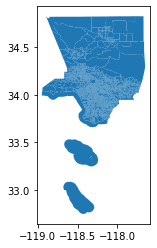

In [403]:
merged.plot()

<AxesSubplot:>

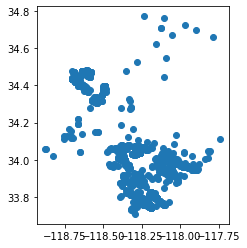

In [404]:
wellsIDLE.plot()

## Spatial Join - Idle Wells and Census Data

In [405]:
wellsIdleFIPS = gpd.sjoin(wellsIDLE, merged, how='left', op='intersects')
wellsIdleFIPS.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3617 entries, 2 to 24232
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   LeaseName                          3617 non-null   object  
 1   WellNumber                         3617 non-null   object  
 2   WellStatus                         3617 non-null   object  
 3   WellType                           3617 non-null   object  
 4   WellTypeLa                         3617 non-null   object  
 5   OperatorCo                         3617 non-null   object  
 6   OperatorNa                         3617 non-null   object  
 7   Latitude                           3617 non-null   float64 
 8   Longitude                          3617 non-null   float64 
 9   geometry                           3617 non-null   geometry
 10  index_right                        3615 non-null   float64 
 11  FIPS                              

## Summarize Well Counts per Census Tract

In [406]:
IdleWellCountsSummary = wellsIdleFIPS.FIPS.value_counts().rename_axis('FIPS').reset_index(name='Idle Well Counts')

In [407]:
IdleWellCountsSummary.head()

,FIPS,Idle Well Counts
0,6.037980e+09,291
1,6.037573e+09,184
2,6.037920e+09,169
3,6.037208e+09,158
4,6.037980e+09,133


In [408]:
# note only 287 census tracts contain wells
IdleWellCountsSummary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FIPS              287 non-null    float64
 1   Idle Well Counts  287 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 4.6 KB


## Re-join Well Counts to Census Tract Data

In [409]:
# merge the datasets
TractIdleWellCounts = merged.merge(IdleWellCountsSummary, # left dataset = census tract shapes, right dataset = well counts
                                                    on='FIPS', # the column to merge with
                                                    how='left', # use a left outer join, which means all of the entries in expulsions will be preserved
                                                    indicator=True) # create a new column '_merge' that tells us how the merge went


In [410]:
TractIdleWellCounts._merge.value_counts()

left_only     2059
both           287
right_only       0
Name: _merge, dtype: int64

In [411]:
# drop the extra column
TractIdleWellCounts = TractIdleWellCounts.drop(labels='_merge',axis='columns')
TractIdleWellCounts.sample(5)

,FIPS,name,geometry,Area Name,Census Tract,Total Population:,Total: White,Total: Black,Total: AmerIndian,Total: Asian,...,% Total: AmerIndian,% Total: Asian,% Total: Hawaiian and PacIslander,% Total: Other,% Total: Mixed,Total: Not Hispanic or Latino,Total: Hispanic or Latino,% Total: Not Hispanic or Latino,% Total: Hispanic or Latino,Idle Well Counts
1773,6037553702,"Census Tract 5537.02, Los Angeles, CA","MULTIPOLYGON (((-118.18812 33.89488, -118.1881...",Census Tract 5537.02,553702,4723,2226,324,0,69,...,0.00,1.46,0.0,43.32,1.23,435,4288,9.21,90.79,1.0
566,6037209200,"Census Tract 2092, Los Angeles, CA","MULTIPOLYGON (((-118.26582 34.05149, -118.2653...",Census Tract 2092,209200,4545,1538,373,0,1271,...,0.00,27.96,1.5,22.68,5.81,2984,1561,65.65,34.35,NaN
1402,6037480600,"Census Tract 4806, Los Angeles, CA","MULTIPOLYGON (((-118.17606 34.11249, -118.1759...",Census Tract 4806,480600,8038,4844,518,15,1752,...,0.19,21.80,0.0,5.37,5.93,6479,1559,80.60,19.40,NaN
795,6037239801,"Census Tract 2398.01, Los Angeles, CA","MULTIPOLYGON (((-118.26952 33.96737, -118.2684...",Census Tract 2398.01,239801,3705,1114,816,127,5,...,3.43,0.13,0.0,42.16,2.19,790,2915,21.32,78.68,NaN
776,6037237800,"Census Tract 2378, Los Angeles, CA","MULTIPOLYGON (((-118.30463 33.96907, -118.3046...",Census Tract 2378,237800,3796,730,1996,61,8,...,1.61,0.21,0.0,23.95,2.42,2252,1544,59.33,40.67,NaN


In [412]:
# replace NaN with 0
TractIdleWellCounts.counts = TractIdleWellCounts['Idle Well Counts'].fillna(0)
TractIdleWellCounts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2346 entries, 0 to 2345
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   FIPS                               2346 non-null   int64   
 1   name                               2346 non-null   object  
 2   geometry                           2346 non-null   geometry
 3   Area Name                          2346 non-null   object  
 4   Census Tract                       2346 non-null   int64   
 5   Total Population:                  2346 non-null   int64   
 6   Total: White                       2346 non-null   int64   
 7   Total: Black                       2346 non-null   int64   
 8   Total: AmerIndian                  2346 non-null   int64   
 9   Total: Asian                       2346 non-null   int64   
 10  Total: Hawaiian and PacIslander    2346 non-null   int64   
 11  Total: Other                       

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:182: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



## Now we plot the data!

In [432]:
def plotly_scatter_wellCounts(xcol = '% Total: White', ycol = 'Idle Well Counts',df = TractIdleWellCounts):
    # a simple scatter plot
    fig = px.scatter(df,
                     x = xcol,
                     y = ycol,
                     title='Number of Idle Wells in Census Tract'
          )

    # show the figure
    fig.show()
    fig.write_html(ycol + xcol[8:]+ '.html')


In [414]:
columns_of_interest = ['% Total: White', '% Total: Black',
       '% Total: AmerIndian', '% Total: Asian',
       '% Total: Hawaiian and PacIslander', '% Total: Other', '% Total: Mixed',
       '% Total: Not Hispanic or Latino', '% Total: Hispanic or Latino']

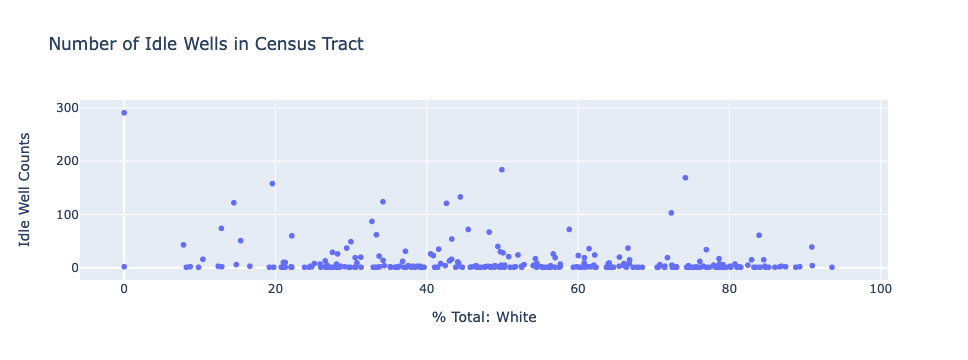

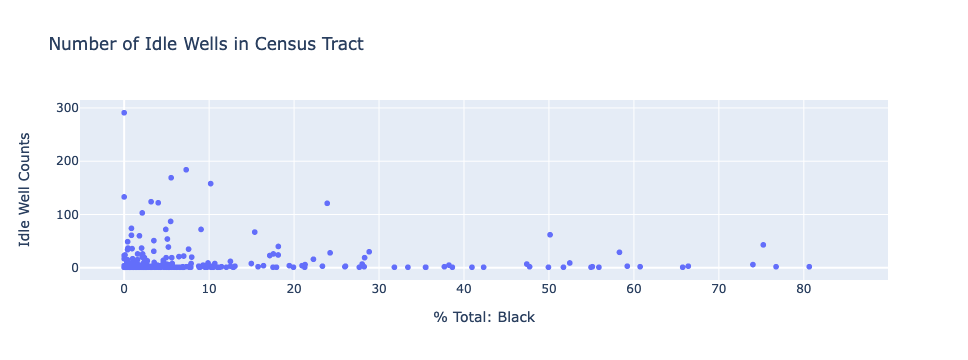

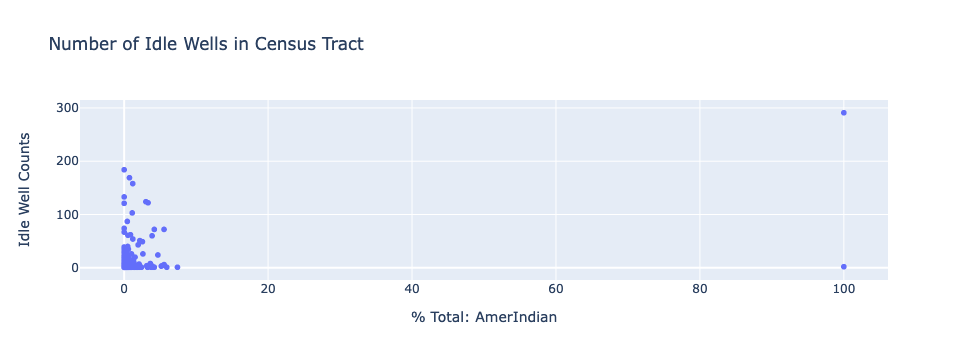

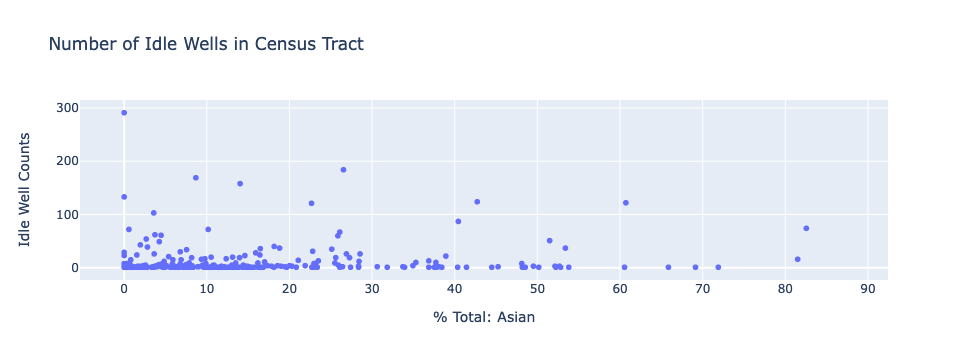

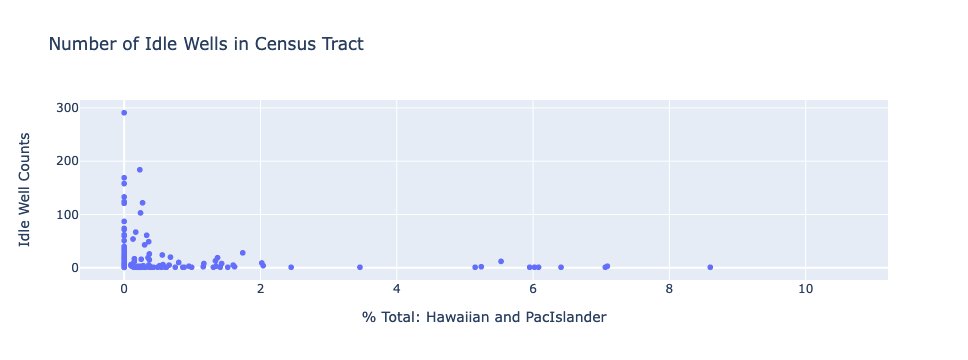

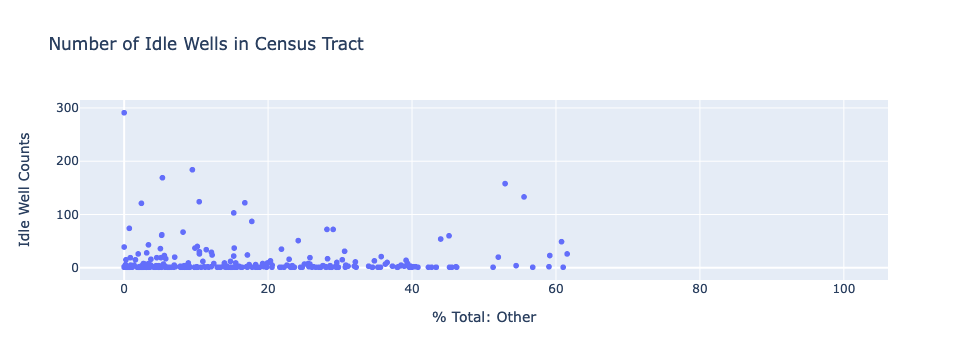

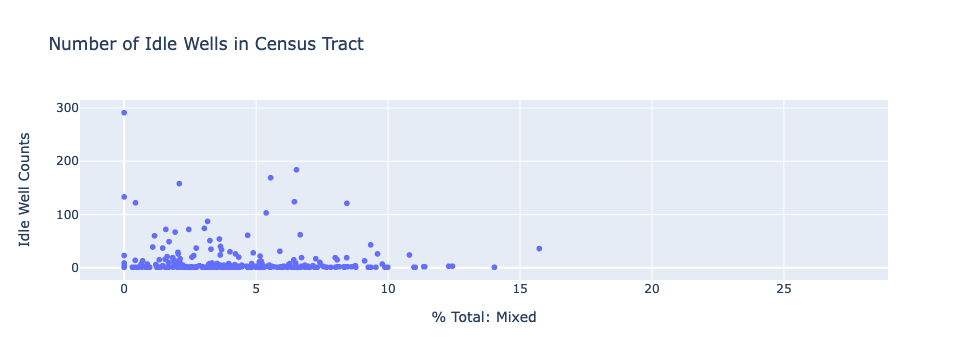

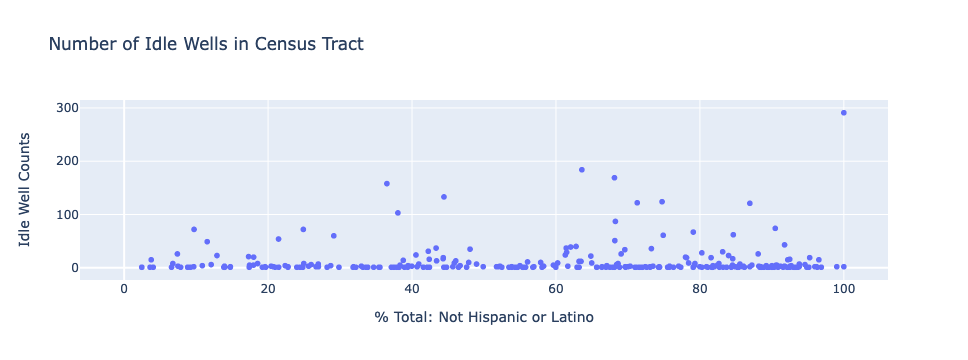

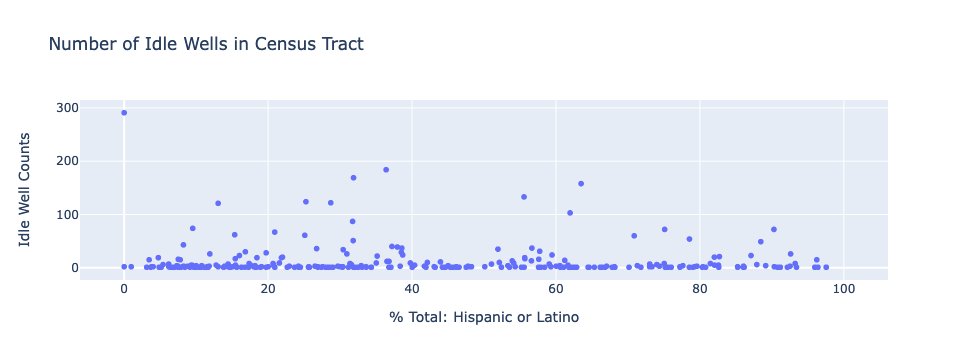

In [433]:
for col in columns_of_interest:
    plotly_scatter_wellCounts(xcol = col)